In [50]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

2.1.2+cu121


In [51]:
from torch import nn # nn contains all of building blocks for neural networks

### 3.1 Machine Learning goals
1. get data into a numerical representation
2. build a model to learn patterns in that numerical representation

In [52]:
# Create *known* parameters (hyperparameters)
weight = 0.7
bias = 0.3

# Create 
start=0
end=1
step=0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias # Linear regression : https://en.wikipedia.org/wiki/Linear_regression
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [53]:
# For comparing the above
X_1 = torch.arange(start, end, step)
y_1 = weight*X_1 + bias
X_1[:10], y_1[:10]

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260]))

In [54]:
len(X), len(y)

(50, 50)

In [55]:
# Create a train/test
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [56]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    prediction=None):
    plt.figure(figsize=(10,7))
    # train data
    plt.scatter(train_data, train_labels, c='b',s=4, label='Train_data')
    # test data
    plt.scatter(test_data, test_labels, c='g',s=4, label='Test_data')
    
    if prediction is not None:
        plt.scatter(test_data, prediction, c='r',s=4, label='Prediction')
    
    plt.legend(prop={"size":14});    

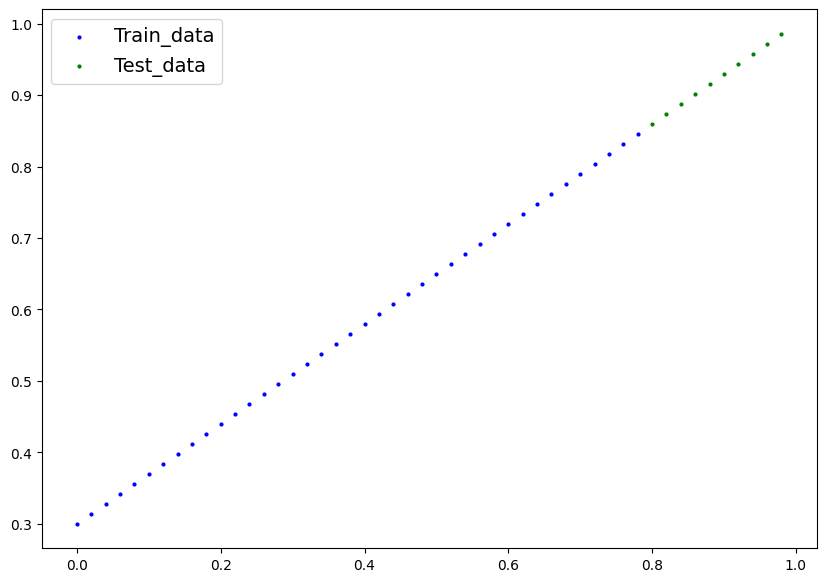

In [57]:
plot_prediction()

In [58]:
# Create linear regression model class from Pytorch doc
class LinearRegressionModel(nn.Module): # calling all nn.Module subclasses
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, # start with a random num
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, # start with a random num
                                             requires_grad=True,
                                             dtype=torch.float))
        '''
        model parameters -> setting up various computations
        requires_grad (this is default setting) -> track the gradients of target parameter for use with torch.autograd
        '''
        
    # Forward method for computation    # nn.Module needs to process of forward
    def forward(self, x:torch.Tensor) -> torch.Tensor: # <- 'x' is input data
        return self.weight * x + self.bias # linear regression formula

**torch.nn:** building all computational functions  
**torch.parameters:** parameters for our model to learn about data by using layers  
**torch.nn.Module:** the base class for all neural network, such as forward()  
**torch.optim:** optimizers  
**torch.forward:**: All nn.Module subclasses require u to overwrite  

### 3.2 Checking the Contents of model

In [59]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

In [60]:
# Create a random seed
torch.manual_seed(42)

# Create a model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [61]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [62]:
weight, bias

(0.7, 0.3)

### 3.3 Make the prediction (simple step)

In [63]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [64]:
# Make prediction
with torch.inference_mode():    # track less gradient descent data, https://pytorch.org/docs/stable/generated/torch.inference_mode.html
    y_preds = model_0(X_test)
print(y_preds)

with torch.no_grad():           # similar to the inference_mode but not recommend
    y_preds = model_0(X_test)  
print(y_preds)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


In [65]:
y_preds_1 = model_0(X_test)     # track all gradient descent data
y_preds_1

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

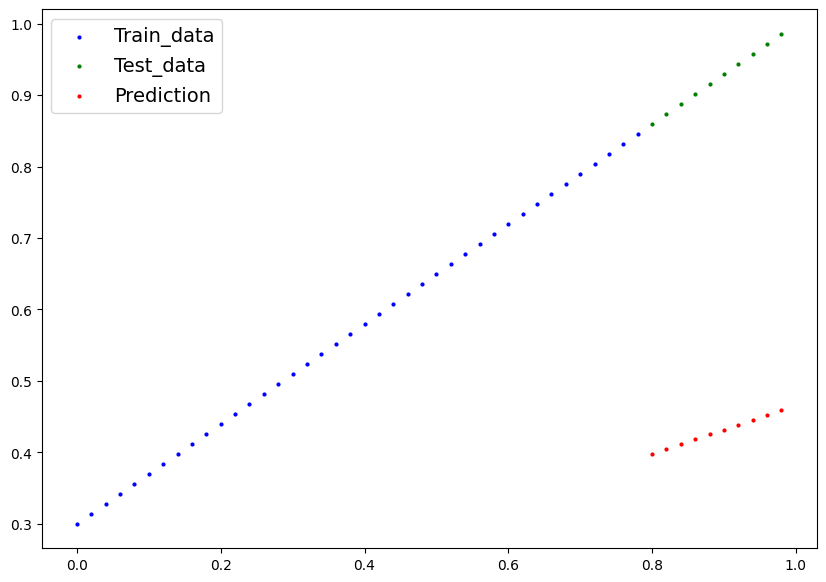

In [66]:
plot_prediction(prediction=y_preds)

### 3.4 train the model(1)

* **Loss function:** a function to measure how wrong model prediction, lower is better
* **Optimizer:** Takes into account the loss of a model and adjust the parameters (weight & bias) to improve the loss function

In Pytorch train:
* train loop
* test loop

In [67]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [68]:
# Check our model's parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [69]:
# Setup a loss function
loss_fn = nn.L1Loss()

# SEtup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # model_0's parameters
                            lr=0.01)

### 3.5 train the model(2)
* traing loop 
1. Loop through the data
2. Forward()
3. Calculate loss
4. Optimizer zero grad
5. Loss backward (back propagation)
6. Optimizer step (gradient descent)

In [70]:
# Epoch setting
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values=[]

# 1. Loop through the data
for epoch in range(epochs):
    ############
    # Training #
    ############
    
    # Set the model to training mode
    model_0.train() # train mode
    
    # 2. Forward()
    y_pred = model_0(X_train)
    
    # 3. Calculate the loss (how different are the model's prediction and true values)
    loss = loss_fn(y_pred, y_train)
    # print(f'Loss:{loss}')
    # 4. Optimizer zero grad (accumulating every epoch and zero setting for memory)
    optimizer.zero_grad()
    
    # 5. back propagation
    loss.backward()
    
    # 6. Optimizer (gradient descent)
    optimizer.step()
    
    ###########
    # Testing #
    ###########
    model_0.eval() # turns off different settings in the model (dropout/batch normalization)
    
    with torch.inference_mode():  # turn off gradient tracking & several back actions
        # 1. forward() again
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    # Print out process
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch:{epoch} | Loss: {loss} | Test loss: {test_loss}')

print(model_0.state_dict())

Epoch:0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch:10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch:20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch:30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch:40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch:50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch:60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch:70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch:80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch:90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch:100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch:110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch:120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch:130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Epoch:140 | Loss

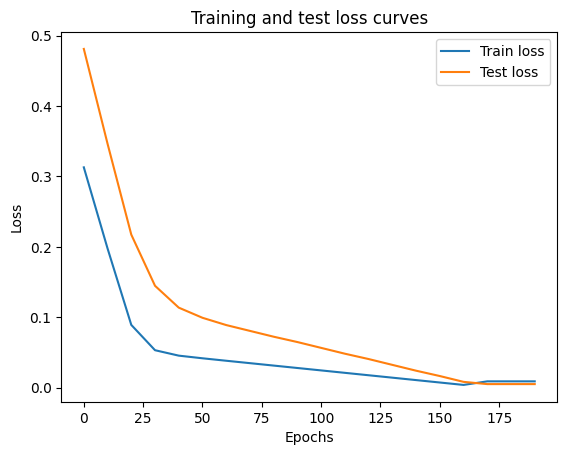

In [71]:
# plot the loss curve
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

In [72]:
with torch.inference_mode():
    y_pred_new = model_0(X_test)

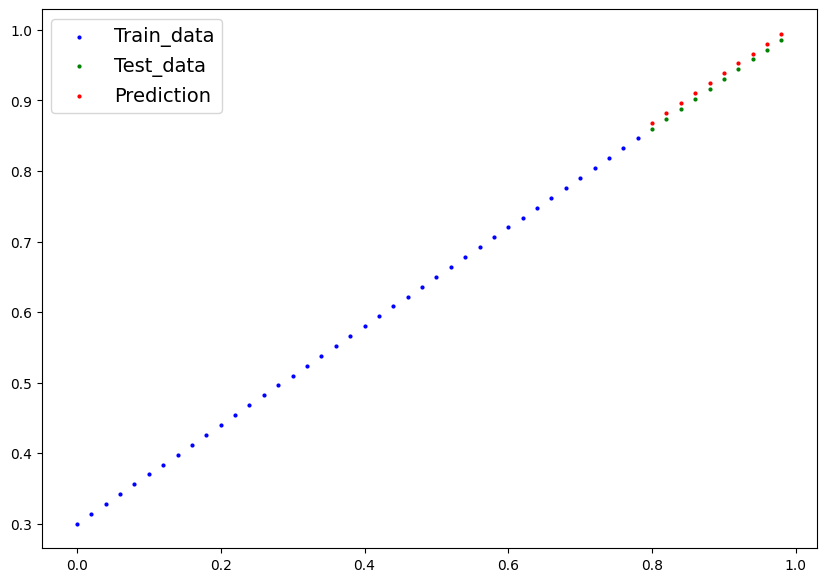

In [73]:
plot_prediction(prediction=y_pred_new)

### 3.6 Saving and Loading model
1. **torch.save():** save pytorch model as python's pickle format(*.pth)
2. **torch.load():** load pytorch model
3. **torch.nn.Module.load_state_dict():** load a model's parameters's dictionary

In [74]:
# Saving model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Crate model save path
MODEL_NAME = 'pytorch_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f'Saving model to:{MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to:models\pytorch_model_0.pth


In [75]:
!ls -l models

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [76]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [77]:
# To load in a saved state_dict we have to instantiate a new instance
loaded_model_0 = LinearRegressionModel()
print(f' BEFORE:{loaded_model_0.state_dict()}')

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(f' AFTER :{loaded_model_0.state_dict()}')
print(f' TRUE Weight: {weight}, bias: {bias}')

 BEFORE:OrderedDict([('weight', tensor([0.2345])), ('bias', tensor([0.2303]))])
 AFTER :OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
 TRUE Weight: 0.7, bias: 0.3


In [78]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

model_0.eval()
with torch.inference_mode():
    ypreds = model_0(X_test)

In [79]:
ypreds==loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 3.7 Simplifying (ALL TOGETHER)

In [80]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy

torch.__version__

'2.1.2+cu121'

In [81]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device: {device}')

Current device: cuda


In [82]:
# Data (linear regression, y = weight * x + bias)
# Create *known* parameters (hyperparameters)
weight = 0.7
bias = 0.3

# Create 
start=0
end=1
step=0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
# Without unsqueeze, errors occurred
y = weight*X + bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [83]:
# Create a train/test
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [84]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    prediction=None):
    plt.figure(figsize=(10,7))
    # train data
    plt.scatter(train_data, train_labels, c='b',s=4, label='Train_data')
    # test data
    plt.scatter(test_data, test_labels, c='g',s=4, label='Test_data')
    
    if prediction is not None:
        plt.scatter(test_data, prediction, c='r',s=4, label='Prediction')
    
    plt.legend(prop={"size":14});    

In [85]:
# Create a linear model
class LinearRegressionModel_V2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        # also called: linear transform, probing layer, fully connected layer, dense layer
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModel_V2()
model_1, model_1.state_dict()

(LinearRegressionModel_V2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [86]:
next(model_1.parameters()).device

device(type='cpu')

In [87]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training
* Loss fn
* Optimizer
* Train loop
* Test loop

In [88]:
# setup loss fn
loss_fn = nn.L1Loss()

# setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.01)

In [89]:
# train loop
torch.manual_seed(42)

epochs =200

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    '''
    Train loop
    '''
    model_1.train()
    
    # 1. Forwad()
    y_pred = model_1(X_train)
    
    # 2. loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer
    optimizer.zero_grad()
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    '''
    TEST loop
    '''
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    # PRINTING>>>>>>
    if epoch % 10 == 0:
        print(f'Epoch:{epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch:0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch:10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch:20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch:30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch:40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch:50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch:60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch:70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch:80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch:90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch:100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch:110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch:120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch:130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch:140 

In [90]:
weight, bias

(0.7, 0.3)

In [91]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

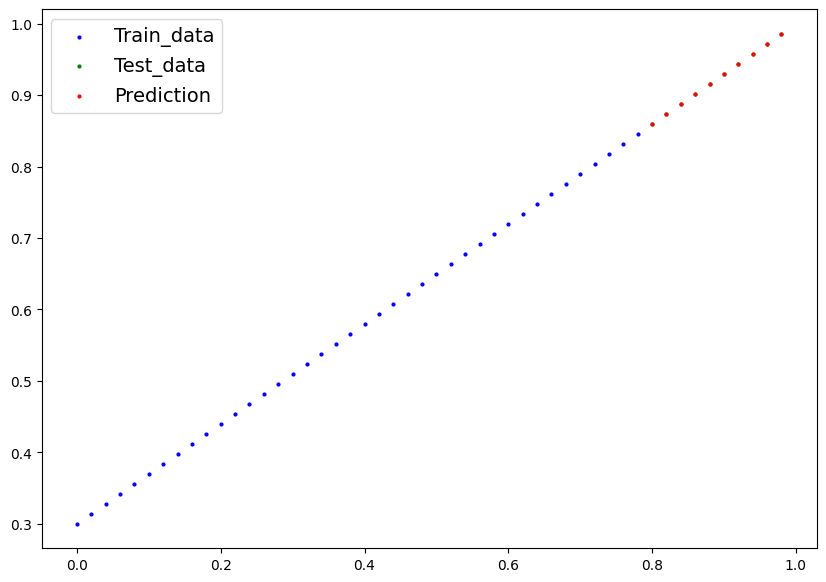

In [92]:
# Check
plot_prediction(prediction=y_preds.cpu())

In [93]:
# Saving model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Crate model save path
MODEL_NAME = 'pytorch_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f'Saving model to:{MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to:models\pytorch_model_1.pth


In [94]:
# Load a Pytorch model

# Create a new instance
loaded_model_1 = LinearRegressionModel_V2()

# load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModel_V2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [95]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [96]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [97]:
# Turn model into evaluation mode
loaded_model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    loaded_model_1_y_preds = loaded_model_1(X_test)
loaded_model_1_y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [98]:
y_preds==loaded_model_1_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')